In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dense, Flatten, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras import losses
from keras.utils import to_categorical
import numpy as np
import os
from scipy.ndimage import imread
from skimage.measure import block_reduce
from sklearn.utils import shuffle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


## Load data

In [2]:
downsample = 2

with open('./essential_data/rec_id2filename.txt', 'r') as f:
    filenames = f.read().split('\n')
filenames = [row.split(',')[1] for row in filenames[1:-1]]

with open('./essential_data/bag_labels.txt', 'r') as f:
    labels = f.read().split('\n')

is_test = np.loadtxt('./essential_data/CVfolds_2.txt', skiprows=1, delimiter=',', usecols=1, dtype=np.int32)

train_name_x = [filename for row, filename in enumerate(filenames) if not is_test[row]]
test_name_x = [filename for row, filename in enumerate(filenames) if is_test[row]]


train_x = np.asarray([block_reduce(imread('./supplemental_data/spectrograms/' + filename + '.bmp'), block_size=(downsample, downsample), func=np.mean) for filename in train_name_x])
test_x = np.asarray([block_reduce(imread('./supplemental_data/spectrograms/' + filename + '.bmp'), block_size=(downsample, downsample), func=np.mean) for filename in test_name_x])

train_x = np.expand_dims(train_x, axis=3)
test_x = np.expand_dims(test_x, axis=3)

y = []
for row in labels[1:-1]:
    row = row.split(',')[1:]
    new_row = np.zeros(19,dtype=np.int32)
    if row[0] != '':
        for nr in row:
            new_row[int(nr)] = 1
    y.append(new_row)

train_y = np.array([y_1 for row, y_1 in enumerate(y) if not is_test[row]])
test_y = np.array([y for row, y in enumerate(y) if is_test[row]])

# Shuffle the training data
train_x, train_y = shuffle(train_x, train_y)

print('Number of training data: ', len(train_y))
print('Number of test data: ', len(test_y))
print('Total number of data: ', len(train_y) + len(test_y))

Number of training data:  322
Number of test data:  323
Total number of data:  645


### Create the model

In [3]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), input_shape=(256//downsample, 1246//downsample, 1)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.3)) # Try with tanh or sigmoid?

model.add(Dropout(0.5))

model.add(Dense(19))
model.add(Activation('sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 619, 16)      416       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 124, 619, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 309, 16)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 309, 16)       64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 305, 32)       12832     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 58, 305, 32)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 152, 32)       0         
__________

### Train the model

In [4]:
hist = model.fit(train_x, train_y, batch_size=8, epochs=10, verbose=1, callbacks=None, validation_split=0.1, shuffle=True)

Train on 289 samples, validate on 33 samples
Epoch 1/10
289/289 [==============================] - 5s - loss: 2.3581 - acc: 0.8199 - val_loss: 5.5019 - val_acc: 0.6523
Epoch 2/10
289/289 [==============================] - 2s - loss: 1.4765 - acc: 0.9026 - val_loss: 4.9701 - val_acc: 0.6858
Epoch 3/10
289/289 [==============================] - 2s - loss: 1.0605 - acc: 0.9326 - val_loss: 1.9228 - val_acc: 0.8740
Epoch 4/10
289/289 [==============================] - 2s - loss: 1.0953 - acc: 0.9308 - val_loss: 1.2493 - val_acc: 0.9203
Epoch 5/10
289/289 [==============================] - 2s - loss: 1.0121 - acc: 0.9364 - val_loss: 1.2077 - val_acc: 0.9250
Epoch 6/10
289/289 [==============================] - 2s - loss: 1.0173 - acc: 0.9363 - val_loss: 1.2325 - val_acc: 0.9234
Epoch 7/10
289/289 [==============================] - 2s - loss: 0.8841 - acc: 0.9450 - val_loss: 1.1568 - val_acc: 0.9282
Epoch 8/10
289/289 [==============================] - 2s - loss: 0.8892 - acc: 0.9448 - val_lo

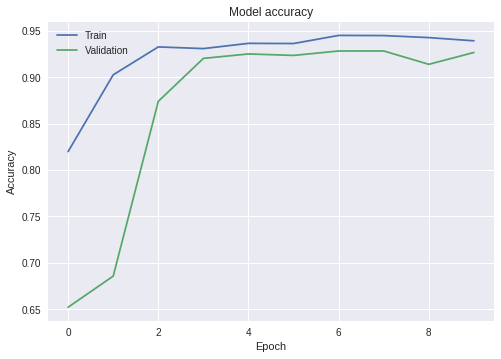

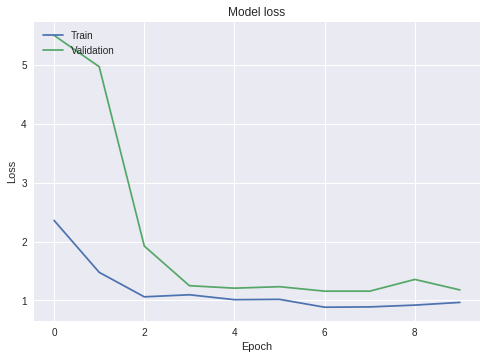

In [5]:
hist.history
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# start_idx = 0
# end_idx = 5
# preds = model.predict(test_x[start_idx:end_idx])

# print(preds)
# print(test_y[start_idx:end_idx])

# preds[preds>=0.5] = 1
# preds[preds<0.5] = 0

# print(preds.astype(np.int32))

In [8]:
preds = model.predict(test_x)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

print('Accuracy on test set: ',np.sum(np.all(preds==test_y,axis=1))/test_y.shape[0])

Accuracy on test set:  0.452012383901


### Evaluate the model (Disregard code below this)

In [ ]:

start_idx = 0
end_idx = 5
print(test_y[start_idx:end_idx])
for i in range(start_idx, end_idx):
    plt.figure()
    plt.imshow(test_x[i, ..., -1])
    plt.show()

In [ ]:
# print('In: ', test_x[0:1])
print('True out:\n', test_y[0:5])
print('Predicted out:\n', model.predict(test_x[0:5]))

In [ ]:
metrics = model.evaluate(test_x, test_y, batch_size=8, verbose=1)
print(model.metrics_names[0], metrics[0], model.metrics_names[1], metrics[1])

In [ ]:
%matplotlib inline
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True)